In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(a=612)

### New-vendor Problem
#### original problem:
$
max_x \ E[f(x)]\\
\\
\ st:\\
\ f(x)=c_s \hat{s}+ c_d \hat{s}' - c_p x\\
\ 0\le \hat{s}\le \min\{x,\hat{d}\}\\
\ 0\le \hat{s}'\le \max\{0,x-\hat{d}\}
$

where $f(x)$ is the profit of purchasing x units; $c_s$ is the unit selling price; $c_d$ is the unit discounted selling price; $c_p$ is the unit purchasing cost; $\hat{s}$ is sales; $\hat{s}'$ is discounted sales;

#### issue:

$E[f(x)]=\int_{0}^{\infty}xf(x)dx \ $    => hard to solve 


#### relaxation:
Assume the uncertainty set $U$ has a finite number of elements. And the problem can be reformulated into a big LP problem:

$
max_x \ \sum_{u\in{U}} p_u \ [ c_s s_u+ c_d s'_u - c_p x]\\
\\
\ st:\\
\ 0\le s_u\le \min\{x,d_u\} \ ,\forall u\in{U}\\
\ 0\le s'_u\le \max\{0,x-d_u\} \ ,\forall u\in{U}
$

reformulate the problem:

$
max_x \ \sum_{u\in{U}} p_u \ [ c_s s_u+ c_d s'_u - c_p x]\\
\\
\ st:\\
\ s_u+s'_u=x\ ,\forall u\in{U}\\ 
\ 0\le s_u\le \alpha_u\ ,\forall u\in{U}\\
\ \alpha_u\le x\ ,\forall u\in{U}\\
\ \alpha_u\le d_u\ ,\forall u\in{U}\\
\ 0\le s'_u\le \beta_u \ ,\forall u\in{U}\\
\ \beta_u\ge 0\ ,\forall u\in{U}\\
\ \beta_u\ge x-d_u\ ,\forall u\in{U}
$

# Demands
#### generating random demands from a normal distribution

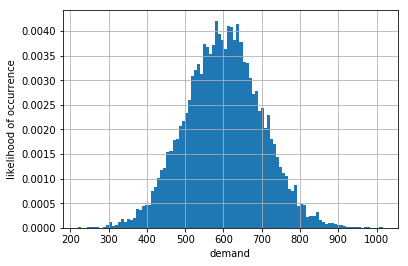

In [2]:
sigma   = 100
mu      = 600
samples = 10000
demand  = [max(random.normalvariate(mu,sigma),0) for i in range(samples)]

Cs=15
Cd=-3
Cp=2

plt.hist(demand,bins=100,density=True)
plt.grid(True)
plt.ylabel("likelihood of occurrence")
plt.xlabel("demand")
plt.show()

# what if x= $\mu$

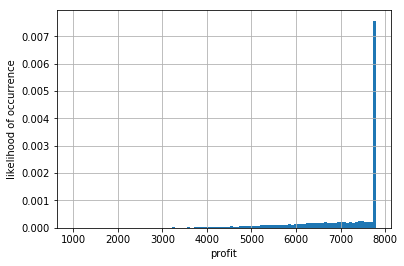

mean profit:7085.97|std :1045.42 | worst case:965.45


In [3]:
x=mu
profit=[Cs*min(x,demand[u])+Cd*max(0,x-demand[u])-Cp*x for u in range(samples)]
plt.hist(profit,bins=100,density=True)
plt.grid(True)
plt.ylabel("likelihood of occurrence")
plt.xlabel("profit")
plt.show()
print("mean profit:{0:.2f}|std :{1:.2f} | worst case:{2:.2f}".format(np.mean(profit),np.std(profit),min(profit)))

# what if x=$\mu+\sigma$

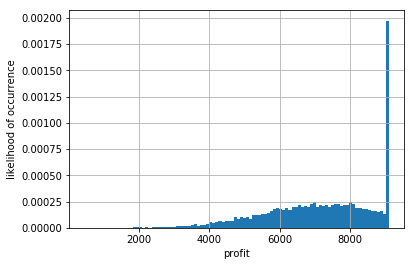

mean profit:7153.98|std :1553.76 | worst case:465.45


In [4]:
x=mu+sigma
profit=[Cs*min(x,demand[u])+Cd*max(0,x-demand[u])-Cp*x for u in range(samples)]
plt.hist(profit,bins=100,density=True)
plt.grid(True)
plt.ylabel("likelihood of occurrence")
plt.xlabel("profit")
plt.show()
print("mean profit:{0:.2f}|std :{1:.2f} | worst case:{2:.2f}".format(np.mean(profit),np.std(profit),min(profit)))

# what if x=$\mu+2\sigma$

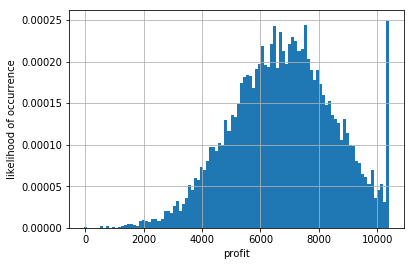

mean profit:6789.07|std :1758.54 | worst case:-34.55


In [5]:
x=mu+2*sigma
profit=[Cs*min(x,demand[u])+Cd*max(0,x-demand[u])-Cp*x for u in range(samples)]
plt.hist(profit,bins=100,density=True)
plt.grid(True)
plt.ylabel("likelihood of occurrence")
plt.xlabel("profit")
plt.show()
print("mean profit:{0:.2f}|std :{1:.2f} | worst case:{2:.2f}".format(np.mean(profit),np.std(profit),min(profit)))

# what if x=$\mu+3\sigma$

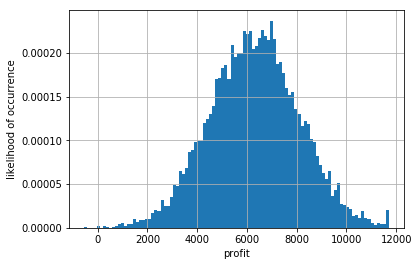

mean profit:6305.31|std :1796.68 | worst case:-534.55


In [6]:
x=mu+3*sigma
profit=[Cs*min(x,demand[u])+Cd*max(0,x-demand[u])-Cp*x for u in range(samples)]
plt.hist(profit,bins=100,density=True)
plt.grid(True)
plt.ylabel("likelihood of occurrence")
plt.xlabel("profit")
plt.show()
print("mean profit:{0:.2f}|std :{1:.2f} | worst case:{2:.2f}".format(np.mean(profit),np.std(profit),min(profit)))

# optimization

$
max_x \ \sum_{u\in{U}} p_u \ [ c_s s_u+ c_d s'_u - c_p x]\\
\\
\ st:\\
\ s_u+s'_u=x\ ,\forall u\in{U}\\ 
\ 0\le s_u\le \alpha_u\ ,\forall u\in{U}\\
\ \alpha_u\le x\ ,\forall u\in{U}\\
\ \alpha_u\le d_u\ ,\forall u\in{U}\\
\ 0\le s'_u\le \beta_u \ ,\forall u\in{U}\\
\ \beta_u\ge 0\ ,\forall u\in{U}\\
\ \beta_u\ge x-d_u\ ,\forall u\in{U}
$

In [7]:
from docplex.mp.model import Model

In [8]:
md1 = Model(name='news-vendor case 1')
x = md1.continuous_var(name="x",lb=0)
s = {(u):md1.continuous_var(name="s_{0}".format(u),lb=0) for u in range(samples)}
sp = {(u):md1.continuous_var(name="sp_{0}".format(u),lb=0) for u in range(samples)}
alpha = {(u):md1.continuous_var(name="alpha_{0}".format(u),lb=0) for u in range(samples)}
beta = {(u):md1.continuous_var(name="beta_{0}".format(u),lb=0) for u in range(samples)}

profit=(1.0/samples)*md1.sum(Cs*s[u]+Cd*sp[u]-Cp*x for u in range(samples))
md1.maximize(profit)

for u in range(samples):
    md1.add_constraint(s[u]+sp[u]==x)
    md1.add_constraint(s[u]<=alpha[u])
    md1.add_constraint(alpha[u]<=x)
    md1.add_constraint(alpha[u]<=demand[u])
    md1.add_constraint(sp[u]<=beta[u])
    md1.add_constraint(beta[u]>=x-demand[u])    

md1.print_information()

Model: news-vendor case 1
 - number of variables: 40001
   - binary=0, integer=0, continuous=40001
 - number of constraints: 60000
   - linear=60000
 - parameters: defaults


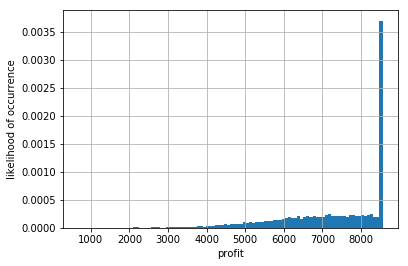

mean profit:7201.48|std :1375.78 | worst case:674.21


In [9]:
md1.solve()
x=md1.solution.as_dict()['x']
profit=[Cs*min(x,demand[u])+Cd*max(0,x-demand[u])-Cp*x for u in range(samples)]
plt.hist(profit,bins=100,density=True)
plt.grid(True)
plt.ylabel("likelihood of occurrence")
plt.xlabel("profit")
plt.show()
print("mean profit:{0:.2f}|std :{1:.2f} | worst case:{2:.2f}".format(np.mean(profit),np.std(profit),min(profit)))

#### solution from the optimization model has a high mean and lower std.

# optimization: maximize the worst case

$
max_x \ w\\
\\
\ st:\\
\ w \le  c_s s_u+ c_d s'_u - c_p x\ ,\forall u\in{U}\\ 
\ s_u+s'_u=x\ ,\forall u\in{U}\\ 
\ 0\le s_u\le \alpha_u\ ,\forall u\in{U}\\
\ \alpha_u\le x\ ,\forall u\in{U}\\
\ \alpha_u\le d_u\ ,\forall u\in{U}\\
\ 0\le s'_u\le \beta_u \ ,\forall u\in{U}\\
\ \beta_u\ge 0\ ,\forall u\in{U}\\
\ \beta_u\ge x-d_u\ ,\forall u\in{U}
$

In [10]:
md2 = Model(name='news-vendor case 2')
w = md2.continuous_var(name="w",lb=-md2.infinity)
x = md2.continuous_var(name="x",lb=0)
s = {(u):md2.continuous_var(name="s_{0}".format(u),lb=0) for u in range(samples)}
sp = {(u):md2.continuous_var(name="sp_{0}".format(u),lb=0) for u in range(samples)}
alpha = {(u):md2.continuous_var(name="alpha_{0}".format(u),lb=0) for u in range(samples)}
beta = {(u):md2.continuous_var(name="beta_{0}".format(u),lb=0) for u in range(samples)}

md2.maximize(w)

for u in range(samples):
    md2.add_constraint(w<=Cs*s[u]+Cd*sp[u]-Cp*x)
    md2.add_constraint(s[u]+sp[u]==x)
    md2.add_constraint(s[u]<=alpha[u])
    md2.add_constraint(alpha[u]<=x)
    md2.add_constraint(alpha[u]<=demand[u])
    md2.add_constraint(sp[u]<=beta[u])
    md2.add_constraint(beta[u]>=x-demand[u])    

md2.print_information()

Model: news-vendor case 2
 - number of variables: 40002
   - binary=0, integer=0, continuous=40002
 - number of constraints: 70000
   - linear=70000
 - parameters: defaults


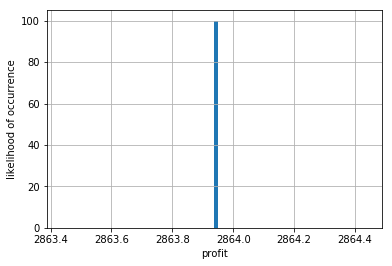

mean profit:2863.94|std :0.00 | worst case:2863.94


In [11]:
md2.solve()
x=md2.solution.as_dict()['x']
profit=[Cs*min(x,demand[u])+Cd*max(0,x-demand[u])-Cp*x for u in range(samples)]
plt.hist(profit,bins=100,density=True)
plt.grid(True)
plt.ylabel("likelihood of occurrence")
plt.xlabel("profit")
plt.show()
print("mean profit:{0:.2f}|std :{1:.2f} | worst case:{2:.2f}".format(np.mean(profit),np.std(profit),min(profit)))